# Пример использования библиотеки BigARTM для тематического моделирования

Импортируем BigARTM:

In [79]:
from matplotlib import pyplot as plt
%matplotlib inline

In [80]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [105]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="/home/egor/data/school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [82]:
batch_vectorizer = artm.BatchVectorizer(data_path="/home/egor/data/school_batches", data_format='batches')
dictionary = artm.Dictionary(data_path='/home/egor/data/school_batches')

Создаем объект модели:

In [83]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1},cache_theta=True)
# число после названия модальностей - это их веса

In [84]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [85]:
#model_artm.gather_dictionary('dictionary', batch_vectorizer.data_path)
dictionary.gather(batch_vectorizer.data_path)
print batch_vectorizer.data_path

/home/egor/data/school_batches


In [86]:
#model_artm.initialize("dictionary", seed=-1)
model_artm.initialize(dictionary=dictionary)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [87]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

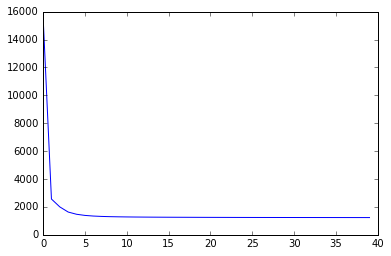

In [88]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [89]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print word,
    print
#model_artm.topic_names
#model_artm.score_tracker["top_words"].last_tokens

sbj0:  быть право который ребенок человек язык они семья это русский время для также свой что
sbj1:  что свой который быть это человек этот его герой она они жизнь ребенок как такой
sbj2:  предложение слово который что например это как быть или речь такой они если мочь этот
sbj3:  который что ядро это этот энергия вода земля быть масса атом как температура такой океан
sbj4:  поэт пушкин что стихотворение который свой это быть звук этот весь лирика год его произведение
sbj5:  x быть a b число этот при функция уравнение что это для если сила ток
sbj6:  который человек свой что жизнь его быть герой это как произведение литература этот для русский
sbj7:  который человек общество развитие социальный государство как политический быть это себя культура жизнь такой отношение
sbj8:  страна государство население который быть территория этот год являться город африка время что также хозяйство
sbj9:  быть который год государство война становиться свой что весь первый военный как время период импер

Давайте посмотрим также на разреженность матриц:

In [90]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.767712280266
0.00189075630252


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [91]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [92]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Попробуем менять коэффициент регуляризации:

In [93]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [94]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [95]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print word,
    print

sbj0:  право ребенок язык свобода семья английский религиозный гражданский быт суд воспитание орган честь the закреплять
sbj1:  жить повесть женщина нет поэма лермонтов написать школа молодой сказка отец хороший любить гоголь умирать
sbj2:  слово например предложение простой какой речь предмет глагол скорость физика имя выступать свет кто угол
sbj3:  земля энергия вода ядро масса движение природный состоять океан частица атом заряд температура располагать южный
sbj4:  пушкин поэт стихотворение писать лирика звук стих поэзия сравнение почти русь ночь былина красота любовный
sbj5:  при x a сила если два число можно b функция пример получать тело равный случай
sbj6:  человек его жизнь герой русский главный произведение мир литература сам история автор литературный личность всегда
sbj7:  общество представлять развитие отношение социальный политический процесс форма система экономический производство культура характер понятие роль
sbj8:  страна территория население город древний северный ми

In [96]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.900726753214
0.0981092436975


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [97]:
model_artm.save("my_model")

In [98]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [99]:
phi = model_artm.get_phi()

In [100]:
phi.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
бета-частица,0.0,0.0,0.0,0.000092,0.0,0.0,0.0,0.0,0.0,0.0
фотопластинка,0.0,0.0,0.0,0.000184,0.0,0.0,0.0,0.0,0.0,0.0
толстостенный,0.0,0.0,0.0,0.000092,0.0,0.0,0.0,0.0,0.0,0.0
неоднородно,0.0,0.0,0.0,0.000092,0.0,0.0,0.0,0.0,0.0,0.0
неделимость,0.0,0.0,0.0,0.000184,0.0,0.0,0.0,0.0,0.0,0.0


Матрица вероятностей тем в документах.

In [101]:
theta = model_artm.get_theta()
theta

,201,202,203,204,205,206,207,208,209,210,...,467,468,469,470,471,472,473,474,475,476
sbj0,0.000000e+00,0.000000,1.065151e-13,0.025773,0.000000,0.005435,0.008621,0.003425,0.015464,0.016597,...,0.012354,0.019920,7.575749e-03,0.004049,0.035326,0.031818,0.043668,0.015669,0.003484,0.017021
sbj1,4.219405e-03,0.000000,1.321587e-02,0.015464,0.004287,0.005435,0.004310,0.094694,0.046632,0.024896,...,0.012245,0.011952,3.586948e-13,0.080972,0.024457,0.172497,0.000000,0.059479,0.019390,0.025532
sbj2,4.219406e-02,0.005076,2.224393e-02,0.036082,0.021277,0.076087,0.043103,0.041096,0.020803,0.013153,...,0.697034,0.020415,0.000000e+00,0.024292,0.475093,0.022727,0.021834,0.014870,0.017582,0.028174
sbj3,5.654010e-01,0.000000,8.810577e-03,0.030928,0.029787,0.036931,0.030172,0.013975,0.093839,0.004209,...,0.012278,0.031872,4.166662e-02,0.028340,0.105978,0.022957,0.004367,0.018587,0.243902,0.031400
sbj4,2.635451e-09,0.000000,4.405288e-03,0.000000,0.004255,0.016834,0.009493,0.030822,0.436664,0.000000,...,0.012245,0.003984,5.058870e-11,0.109312,0.014037,0.077273,0.004501,0.007435,0.222360,0.012766
sbj5,2.869198e-01,0.964467,8.454157e-01,0.046392,0.893278,0.743329,0.073276,0.079964,0.020619,0.041494,...,0.098303,0.027888,2.651512e-02,0.040486,0.182065,0.013845,0.030568,0.022305,0.031586,0.055319
sbj6,2.109703e-02,0.010152,3.524230e-02,0.144330,0.008511,0.034427,0.167232,0.136986,0.206186,0.042101,...,0.073630,0.036121,2.651512e-02,0.542510,0.051630,0.311476,0.043668,0.715695,0.010453,0.476596
sbj7,5.063287e-02,0.005076,2.220811e-02,0.494845,0.012953,0.043478,0.099138,0.458628,0.020619,0.045643,...,0.028571,0.111554,7.627601e-02,0.028340,0.065217,0.090701,0.122271,0.063197,0.014005,0.217021
sbj8,1.687762e-02,0.010152,1.321586e-02,0.118557,0.000000,0.005435,0.301724,0.013699,0.036082,0.289085,...,0.012437,0.107570,7.419060e-01,0.020243,0.021739,0.013636,0.091703,0.022305,0.269990,0.055319
sbj9,1.265822e-02,0.005076,3.524230e-02,0.087629,0.025651,0.032609,0.262931,0.126712,0.103093,0.522822,...,0.040903,0.628723,7.954536e-02,0.121458,0.024457,0.243070,0.637420,0.060458,0.167247,0.080851


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [103]:
theta_test = model_artm.transform(batch_vectorizer)

In [104]:
theta_test

,201,202,203,204,205,206,207,208,209,210,...,467,468,469,470,471,472,473,474,475,476
sbj0,0.000000e+00,0.000000,1.054998e-13,0.025773,0.000000,0.005435,0.008621,0.003425,0.015464,0.016597,...,0.012354,0.019920,7.575760e-03,0.004049,0.035326,0.031818,0.043668,0.015735,0.003484,0.017021
sbj1,4.219405e-03,0.000000,1.321584e-02,0.015464,0.004276,0.005435,0.004310,0.094343,0.046631,0.024896,...,0.012245,0.011952,3.592672e-13,0.080972,0.024457,0.172502,0.000000,0.059480,0.021103,0.025532
sbj2,4.219406e-02,0.005076,2.223764e-02,0.036082,0.021277,0.076087,0.043103,0.041096,0.020803,0.013154,...,0.697033,0.020415,0.000000e+00,0.024292,0.475131,0.022727,0.021834,0.014870,0.017582,0.028198
sbj3,5.654010e-01,0.000000,8.810561e-03,0.030928,0.029787,0.036936,0.030172,0.013972,0.093839,0.004209,...,0.012278,0.031872,4.166668e-02,0.028340,0.105978,0.022953,0.004367,0.018587,0.243903,0.031377
sbj4,2.733638e-09,0.000000,4.405281e-03,0.000000,0.004255,0.016834,0.009484,0.030822,0.436665,0.000000,...,0.012245,0.003984,5.024269e-11,0.109312,0.013999,0.077273,0.004499,0.007435,0.222343,0.012766
sbj5,2.869197e-01,0.964467,8.454222e-01,0.046392,0.893289,0.743327,0.073276,0.080315,0.020619,0.041494,...,0.098304,0.027888,2.651516e-02,0.040486,0.182065,0.013845,0.030568,0.022305,0.031587,0.055319
sbj6,2.109703e-02,0.010152,3.524224e-02,0.144330,0.008511,0.034425,0.167240,0.136986,0.206186,0.042109,...,0.073630,0.036109,2.651516e-02,0.542510,0.051630,0.312023,0.043668,0.715615,0.010453,0.476596
sbj7,5.063287e-02,0.005076,2.220808e-02,0.494845,0.012953,0.043478,0.099138,0.458630,0.020619,0.045643,...,0.028571,0.111554,7.627939e-02,0.028340,0.065217,0.090701,0.122271,0.063197,0.014005,0.217021
sbj8,1.687762e-02,0.010152,1.321584e-02,0.118557,0.000000,0.005435,0.301724,0.013699,0.036082,0.289076,...,0.012437,0.107570,7.419024e-01,0.020243,0.021739,0.013636,0.091703,0.022305,0.268292,0.055319
sbj9,1.265822e-02,0.005076,3.524224e-02,0.087629,0.025651,0.032609,0.262931,0.126712,0.103093,0.522822,...,0.040903,0.628735,7.954549e-02,0.121458,0.024457,0.242523,0.637422,0.060472,0.167247,0.080851
